<a href="https://colab.research.google.com/github/Diya-Amith/Data-Science-Project-Galaxy-Morphology-Classification-Using-Deep-Learning-and-Explainable-AI-/blob/main/GalaxyMorphologyClassification_DSProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initial Data Loading**

In [1]:
# Mount Google Drive
from google.colab import drive
import os
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


drive.mount('/content/drive')

# Define paths for dataset
data_dir = '/content/drive/MyDrive/galaxy-zoo-the-galaxy-challenge'
train_images_dir = os.path.join(data_dir, 'images_training_rev1', 'images_training_rev1')
labels_file = os.path.join(data_dir, 'training_solutions_rev1', 'training_solutions_rev1.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load and Clean Labels**

In [2]:
# Load labels
try:
    labels_df = pd.read_csv(labels_file)
    labels_df.set_index('GalaxyID', inplace=True)  # Set GalaxyID as the index
    print("Labels loaded successfully.")
except FileNotFoundError:
    print("Error: Labels file not found. Check the path and filename.")

# Verify a sample of Galaxy IDs to match images
print("Sample GalaxyIDs from labels file:", labels_df.index[:10])

# Initialize lists to store images and labels
files = os.listdir(train_images_dir)
print(f"Total images in directory: {len(files)}")
print(f"Missing images: {[str(img_id) + '.jpg' for img_id in labels_df.index if f'{img_id}.jpg' not in files]}")

# Assuming the labels in labels_df do not have '.jpg' extension
missing_images = [str(img_id) for img_id in labels_df.index if f'{img_id}.jpg' not in files]

# Remove corresponding labels from the dataframe
labels_df_cleaned = labels_df.drop(labels=missing_images, errors='ignore')

# Verify the result
print(f"Cleaned labels dataframe shape: {labels_df_cleaned.shape}")
print(labels_df_cleaned.head())


Labels loaded successfully.
Sample GalaxyIDs from labels file: Index([100008, 100023, 100053, 100078, 100090, 100122, 100123, 100128, 100134,
       100143],
      dtype='int64', name='GalaxyID')
Total images in directory: 17499
Missing images: ['358064.jpg', '358083.jpg', '358091.jpg', '358093.jpg', '358101.jpg', '358103.jpg', '358109.jpg', '358125.jpg', '358143.jpg', '358161.jpg', '358167.jpg', '358171.jpg', '358186.jpg', '358219.jpg', '358237.jpg', '358239.jpg', '358269.jpg', '358273.jpg', '358277.jpg', '358291.jpg', '358304.jpg', '358316.jpg', '358338.jpg', '358341.jpg', '358343.jpg', '358345.jpg', '358347.jpg', '358363.jpg', '358365.jpg', '358393.jpg', '358426.jpg', '358445.jpg', '358458.jpg', '358460.jpg', '358465.jpg', '358468.jpg', '358487.jpg', '358505.jpg', '358511.jpg', '358521.jpg', '358534.jpg', '358538.jpg', '358583.jpg', '358590.jpg', '358622.jpg', '358623.jpg', '358651.jpg', '358660.jpg', '358664.jpg', '358679.jpg', '358735.jpg', '358764.jpg', '358827.jpg', '358857.jpg'

# **Define Image Preprocessing Function**

In [3]:
# Load the labels file into a DataFrame
labels_file = os.path.join(data_dir, 'training_solutions_rev1', 'training_solutions_rev1.csv')
df_galaxies = pd.read_csv(labels_file)

# Check the first few rows of the dataset to understand its structure
print(df_galaxies.head())  # This will show the first 5 rows of df_galaxies

# Make sure 'class' column exists, if not, define it based on conditions
if 'class' not in df_galaxies.columns:
    conditions = [
        df_galaxies['Class1.1'] >= 0.8,  # or any other logic based on the dataset
        df_galaxies['Class1.2'] >= 0.8
    ]
    choices = ['spiral', 'elliptical']
    df_galaxies['class'] = np.select(conditions, choices, default='unknown')

# Filter galaxies by class and sample the required number
df_spiral = df_galaxies[df_galaxies['class'] == 'spiral'].sample(n=8000, random_state=42)
df_elliptical = df_galaxies[df_galaxies['class'] == 'elliptical'].sample(n=8000, random_state=42)

# Concatenate both spiral and elliptical galaxies into one DataFrame
df_galaxies = pd.concat([df_spiral, df_elliptical])

# Reset index and verify that 'GalaxyID' and 'class' are in the DataFrame
df_galaxies = df_galaxies.reset_index(drop=True)

# Print the columns to ensure 'class' is included
print(df_galaxies.columns)  # Check that 'class' is a column
print(df_galaxies.head())  # Check the first few rows to verify


   GalaxyID  Class1.1  Class1.2  Class1.3  Class2.1  Class2.2  Class3.1  \
0    100008  0.383147  0.616853  0.000000  0.000000  0.616853  0.038452   
1    100023  0.327001  0.663777  0.009222  0.031178  0.632599  0.467370   
2    100053  0.765717  0.177352  0.056931  0.000000  0.177352  0.000000   
3    100078  0.693377  0.238564  0.068059  0.000000  0.238564  0.109493   
4    100090  0.933839  0.000000  0.066161  0.000000  0.000000  0.000000   

   Class3.2  Class4.1  Class4.2  ...  Class9.3  Class10.1  Class10.2  \
0  0.578401  0.418398  0.198455  ...  0.000000   0.279952   0.138445   
1  0.165229  0.591328  0.041271  ...  0.018764   0.000000   0.131378   
2  0.177352  0.000000  0.177352  ...  0.000000   0.000000   0.000000   
3  0.129071  0.189098  0.049466  ...  0.000000   0.094549   0.000000   
4  0.000000  0.000000  0.000000  ...  0.000000   0.000000   0.000000   

   Class10.3  Class11.1  Class11.2  Class11.3  Class11.4  Class11.5  Class11.6  
0   0.000000   0.000000   0.092886 

In [7]:
# Define the image loading and preprocessing function
import tensorflow as tf

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = tf.io.read_file(image_path)  # Read the image file
    img = tf.image.decode_jpeg(img, channels=3)  # Decode the image as RGB
    img = tf.image.resize(img, target_size)  # Resize the image to target size
    img = img / 255.0  # Normalize the image to [0, 1]
    return img

# Update the image path construction to reflect the correct folder structure
images_folder = '/content/drive/MyDrive/galaxy-zoo-the-galaxy-challenge/images_training_rev1/images_training_rev1'

# Construct the correct image paths
image_paths = [os.path.join(images_folder, f"{img_id}.jpg") for img_id in df_galaxies['GalaxyID']]

# Verify if the images exist in the directory
existing_image_paths = [img_path for img_path in image_paths if os.path.isfile(img_path)]

# Print the number of existing images
print(f"Number of existing images: {len(existing_image_paths)}")

# Update the code to use the correct preprocessing function
images = np.array([load_and_preprocess_image(img_path) for img_path in existing_image_paths])

# Check the shape of the preprocessed images
print(f"Shape of preprocessed images: {images.shape}")

Number of existing images: 4469
Shape of preprocessed images: (4469, 224, 224, 3)


# **Create TensorFlow Dataset**

In [8]:
# Create a list of image paths from the labels dataframe
image_paths = [os.path.join(train_images_dir, f"{img_id}.jpg") for img_id in labels_df_cleaned.index]

# Create a TensorFlow dataset from the list of image paths
dataset = tf.data.Dataset.from_tensor_slices(image_paths)

# Map the load and preprocess function onto the dataset
dataset = dataset.map(lambda x: load_and_preprocess_image(x, target_size=(128, 128)), num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch the dataset for efficient training
dataset = dataset.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Verify that the dataset is ready
for images in dataset.take(1):
    print(f"Batch shape: {images.shape}")


Batch shape: (32, 128, 128, 3)


# **Install Keras and Define Image Loading Function**

In [9]:
!pip install keras

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to load and preprocess images
def load_and_process_image(galaxy_id):
    img_filename = f"{int(galaxy_id)}.jpg"
    img_path = os.path.join(train_images_dir, img_filename)
    if os.path.isfile(img_path):
        img = Image.open(img_path).resize((128, 128), Image.LANCZOS).convert('RGB')
        img_array = np.array(img) / 255.0  # Normalize image
        return img_array
    else:
        return None


# **Load Image Data with Multiprocessing**

In [10]:
# Set a limit for the number of images to load, e.g., 5000 images
subset_size = 5000
sampled_galaxy_ids = np.random.choice(labels_df_cleaned.index, subset_size, replace=False)

# Parallelize the image loading process using multiprocessing
from multiprocessing import Pool

with Pool() as pool:
    images = pool.map(load_and_process_image, sampled_galaxy_ids)

# Remove any None entries (if any image couldn't be loaded)
images = [img for img in images if img is not None]

# Convert images to a NumPy array
images = np.array(images)

print(f"Loaded {len(images)} images.")


Loaded 1421 images.


# **Extract Labels and Augment Data**

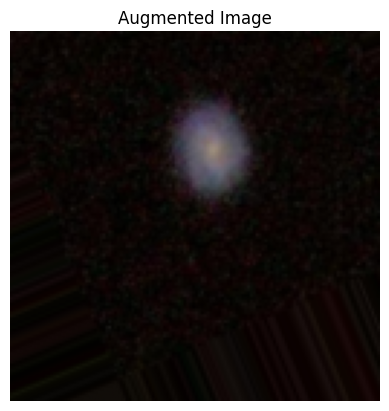

In [11]:
# Extract the corresponding labels for the sampled Galaxy IDs
labels_subset = labels_df_cleaned.loc[sampled_galaxy_ids].values  # This gives the labels as an array

# Data Augmentation Example
datagen = ImageDataGenerator(
    rotation_range=30,  # Rotate image by up to 30 degrees
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in/out
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill empty pixels after transformation
)

# Apply augmentation to the image data (example for the first image in the dataset)
datagen.fit(images)  # Fit the generator to your images

# Optionally, augment a single image to see the effect
augmented_image = datagen.random_transform(images[0])
plt.imshow(augmented_image)
plt.title("Augmented Image")
plt.axis('off')
plt.show()


# **Extract Local Binary Pattern (LBP) Features**

In [12]:
from skimage.feature import local_binary_pattern

# Function to extract Local Binary Pattern (LBP) features from an image
def extract_lbp_features(image):
    # Parameters for LBP
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')

    # Compute the histogram of LBP values
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

    # Normalize the histogram
    lbp_hist = lbp_hist.astype('float')
    lbp_hist /= lbp_hist.sum()

    return lbp_hist

# Extract LBP features from all images
lbp_features = [extract_lbp_features(np.mean(img, axis=-1)) for img in images]  # Convert images to grayscale

# Convert features to a NumPy array
lbp_features = np.array(lbp_features)

print(f"Extracted LBP features from {len(lbp_features)} images.")


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Extracted LBP features from 1421 images.


# **Combine Features with Labels**

In [13]:
# Check initial lengths of images and labels
print(f"Initial number of images: {len(images)}")
print(f"Initial number of labels: {len(labels_subset)}")

# Step 1: Filter out None images before feature extraction
valid_images = []
valid_labels = []

for i, img in enumerate(images):
    if img is not None:
        valid_images.append(img)
        valid_labels.append(labels_subset[i])  # Ensure label alignment

# Convert to NumPy array
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)

# Confirm shapes after filtering
print(f"Filtered number of images: {len(valid_images)}")
print(f"Filtered number of labels: {len(valid_labels)}")

# Step 2: Extract LBP features from valid images
lbp_features = [extract_lbp_features(np.mean(img, axis=-1)) for img in valid_images]
lbp_features = np.array(lbp_features)

# Confirm shapes of features and labels
print(f"LBP features shape: {lbp_features.shape}")
print(f"Labels shape: {valid_labels.shape}")

# Step 3: Combine features and labels if they match
if lbp_features.shape[0] == valid_labels.shape[0]:
    final_dataset = np.hstack((lbp_features, valid_labels))
    print(f"Final dataset shape: {final_dataset.shape}")
else:
    print("Error: The number of LBP features does not match the number of labels.")
    print(f"Number of LBP features: {lbp_features.shape[0]}")
    print(f"Number of labels: {valid_labels.shape[0]}")


Initial number of images: 1421
Initial number of labels: 5000
Filtered number of images: 1421
Filtered number of labels: 1421
LBP features shape: (1421, 10)
Labels shape: (1421, 37)
Final dataset shape: (1421, 47)


# **EDA**

## **Summary statistics**

In [14]:
import pandas as pd

# Assuming 'final_dataset' contains LBP features and labels combined
# Convert it to a DataFrame for better manipulation
final_df = pd.DataFrame(final_dataset)

# Get summary statistics for the dataset
summary_stats = final_df.describe()
print(summary_stats)


                0            1            2            3            4   \
count  1421.000000  1421.000000  1421.000000  1421.000000  1421.000000   
mean      0.065469     0.081986     0.072894     0.120611     0.126202   
std       0.025435     0.016083     0.008591     0.030310     0.051275   
min       0.009094     0.033447     0.033081     0.062073     0.054749   
25%       0.045288     0.072266     0.068481     0.093689     0.085510   
50%       0.066284     0.086548     0.074463     0.119995     0.111633   
75%       0.086975     0.094727     0.078857     0.147705     0.154175   
max       0.117065     0.106628     0.093079     0.191833     0.306641   

                5            6            7            8            9   ...  \
count  1421.000000  1421.000000  1421.000000  1421.000000  1421.000000  ...   
mean      0.095447     0.073223     0.083673     0.134278     0.146216  ...   
std       0.030440     0.006698     0.016321     0.028617     0.041151  ...   
min       0.05499

## **Checking for missing data**

In [15]:
# Check for missing values in the dataset
missing_data = final_df.isnull().sum()
print("Missing values:\n", missing_data)


Missing values:
 0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
dtype: int64


## **Visualizing LBP Features Distribution**

<Figure size 1500x1000 with 0 Axes>

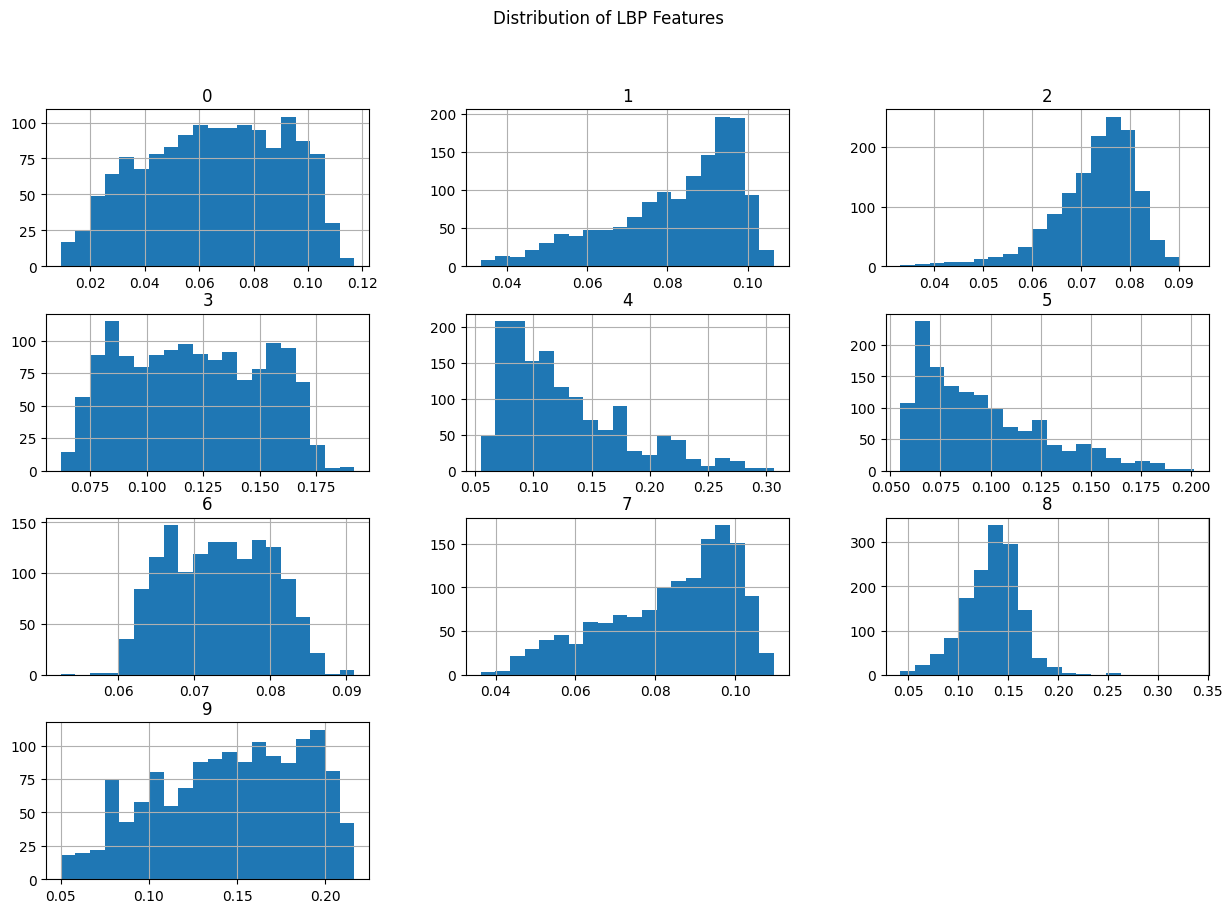

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for each LBP feature
plt.figure(figsize=(15, 10))
final_df.iloc[:, :-37].hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribution of LBP Features")
plt.show()


## **Visualizing Label Distribution**

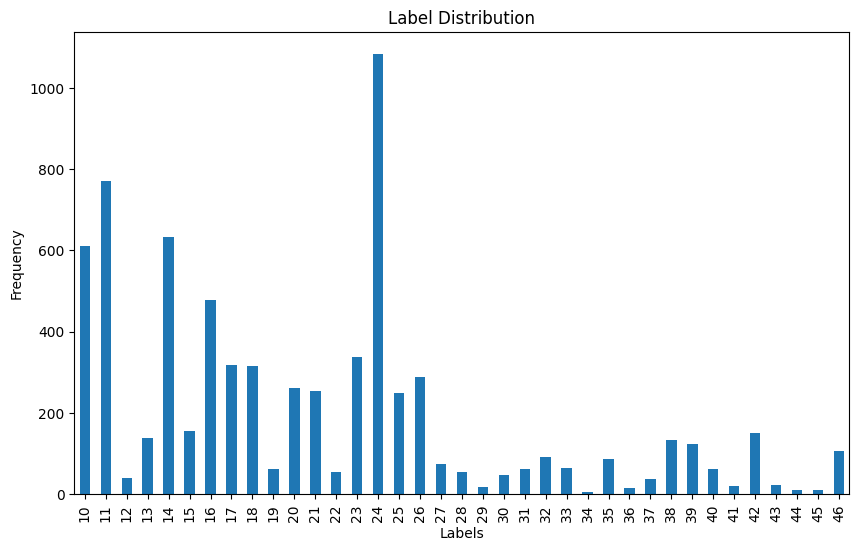

In [17]:
# Check label distribution (assuming labels are in the last 37 columns)
label_counts = final_df.iloc[:, -37:].sum(axis=0)

# Plot the distribution of labels
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.show()


## ** Data Splitting**

In [23]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(valid_images, valid_labels, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalize the images by dividing by 255 to scale pixel values to [0, 1]
X_train_scaled = X_train / 255.0
X_val_scaled = X_val / 255.0
X_test_scaled = X_test / 255.0

# Verify the shapes of the splits after scaling
print(f"Training set shape: X_train = {X_train_scaled.shape}, y_train = {y_train.shape}")
print(f"Validation set shape: X_val = {X_val_scaled.shape}, y_val = {y_val.shape}")
print(f"Test set shape: X_test = {X_test_scaled.shape}, y_test = {y_test.shape}")


Training set shape: X_train = (908, 128, 128, 3), y_train = (908, 37)
Validation set shape: X_val = (228, 128, 128, 3), y_val = (228, 37)
Test set shape: X_test = (285, 128, 128, 3), y_test = (285, 37)


## **ResNet50 Model Implementation**

In [25]:
# Import the necessary libraries
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Step 1: Load the ResNet50 base model with pre-trained weights from ImageNet
base_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the base model (pre-trained layers will not be updated during training)
for layer in base_resnet50.layers:
    layer.trainable = False

# Step 3: Add custom layers on top of the pre-trained base model
x = base_resnet50.output
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce the feature maps
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification (spiral vs elliptical)

# Step 4: Create the complete model
model = Model(inputs=base_resnet50.input, outputs=output)

# Step 5: Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
# Step 6: Define callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('resnet50_best_model.keras', monitor='val_loss', save_best_only=True)  # Change extension to .keras
]



Epoch 1/20


ValueError: Input 0 of layer "functional_3" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 128, 128, 3)